In [6]:
import pyodbc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

server = 'mia10.database.windows.net'
database = 'mia10_db'
username = 'user_reader'
password = '7R&o&o4#~756^z'
driver = '{ODBC Driver 17 for SQL Server}'

connection_string = f'DRIVER={driver};SERVER={server};PORT=1433;DATABASE={database};UID={username};PWD={password}'

conn = pyodbc.connect(connection_string)

query = '''
SELECT m.slug_game, m.event_title, m.medal_type, c.country_name, e.game_year
FROM medals m
JOIN events e ON LOWER(REPLACE(m.slug_game, '-', ' ')) = LOWER(e.game_name)
JOIN country c ON m.athlete_country_id = c.country_id
WHERE e.game_season = 'Summer'
'''

df = pd.read_sql(query, conn, index_col=None)

conn.close()

df.head(10)


/tmp/ipykernel_304424/1242715493.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, index_col=None)


,slug_game,event_title,medal_type,country_name,game_year
0,munich-1972,twoperson keelboat open Star mixed,SILVER,Sweden,1972
1,munich-1972,twoperson keelboat open Star mixed,SILVER,Sweden,1972
2,montreal-1976,tempest mixed,GOLD,Sweden,1976
3,montreal-1976,tempest mixed,GOLD,Sweden,1976
4,los-angeles-1932,twoperson keelboat open Star mixed,BRONZE,Sweden,1932
5,los-angeles-1984,K2 500m kayak double men,SILVER,Sweden,1984
6,los-angeles-1984,K2 500m kayak double men,SILVER,Sweden,1984
7,los-angeles-1984,K1 500m kayak single men,SILVER,Sweden,1984
8,los-angeles-1984,K2 500m kayak double women,GOLD,Sweden,1984
9,los-angeles-1984,K1 500m kayak single women,GOLD,Sweden,1984


In [7]:
countries_rio_2016 = df[df['slug_game'] == 'rio-2016']['country_name'].unique()
df_filtered = df[df['country_name'].isin(countries_rio_2016)]

# grouper par pays, édition et type de médaille
grouped = df_filtered.groupby(['country_name', 'slug_game', 'medal_type']).size().unstack(fill_value=0)

grouped.columns = [f'{col}_count' for col in grouped.columns]

grouped.reset_index(inplace=True)

grouped.head(1000)

,country_name,slug_game,BRONZE_count,GOLD_count,SILVER_count
0,Argentina,athens-2004,4,0,0
1,Argentina,atlanta-1996,0,0,1
2,Argentina,barcelona-1992,2,0,0
3,Argentina,beijing-2008,2,2,0
4,Argentina,berlin-1936,2,0,0
...,...,...,...,...,...
422,United States of America,rome-1960,2,0,0
423,United States of America,seoul-1988,4,9,6
424,United States of America,sydney-2000,6,9,6
425,United States of America,tokyo-1964,3,0,7


In [8]:
encoder = OneHotEncoder(sparse_output=False)
country_encoded = encoder.fit_transform(grouped[['country_name']])
country_encoded_df = pd.DataFrame(country_encoded, columns=encoder.get_feature_names_out(['country_name']))

grouped = pd.concat([grouped, country_encoded_df], axis=1)  # Ajouter les colonnes encodées au DataFrame

# caractéristiques supplémentaires
grouped['total_medals'] = grouped['BRONZE_count'] + grouped['GOLD_count'] + grouped['SILVER_count']
grouped['gold_silver_diff'] = grouped['GOLD_count'] - grouped['SILVER_count']
grouped['gold_bronze_diff'] = grouped['GOLD_count'] - grouped['BRONZE_count']

# préparation des données pour LSTM
def create_sequences(data, time_steps=3):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps), 2:].values)
        ys.append(data.iloc[i + time_steps, [3, 4, 2]].values)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

# séquences
time_steps = 3
X_seq, y_seq = create_sequences(grouped, time_steps)

# Standardiser les données
scaler = StandardScaler()
X_seq_shape = X_seq.shape
X_seq = scaler.fit_transform(X_seq.reshape(-1, X_seq.shape[-1])).reshape(X_seq_shape)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Remodeler les données pour LSTM
X_train = X_train.reshape(X_train.shape[0], time_steps, -1)
X_test = X_test.reshape(X_test.shape[0], time_steps, -1)

# LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))

model.compile(optimizer='adam', loss='mean_squared_error')

# early stopping -> pas d'overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Évaluer le modèle
y_pred = model.predict(X_test)

# évaluer
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Epoch 1/100
9/9 [==============================] - 2s 56ms/step - loss: 9.5523 - val_loss: 9.8601
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 9.1981 - val_loss: 9.6101
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 8.7680 - val_loss: 9.2652
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 8.0357 - val_loss: 8.7442
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 7.1740 - val_loss: 8.1012
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 6.1451 - val_loss: 7.6400
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 5.5910 - val_loss: 7.3604
Epoch 8/100
9/9 [==============================] - 0s 5ms/step - loss: 5.4562 - val_loss: 7.1431
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 5.3622 - val_loss: 6.8811
Epoch 10/100
9/9 [==============================] - 0s 5ms/step - loss: 5.1863 - val_loss: 6.8167
Epoch 11/100
9/9 [=========

3/3 [==============================] - 0s 2ms/step


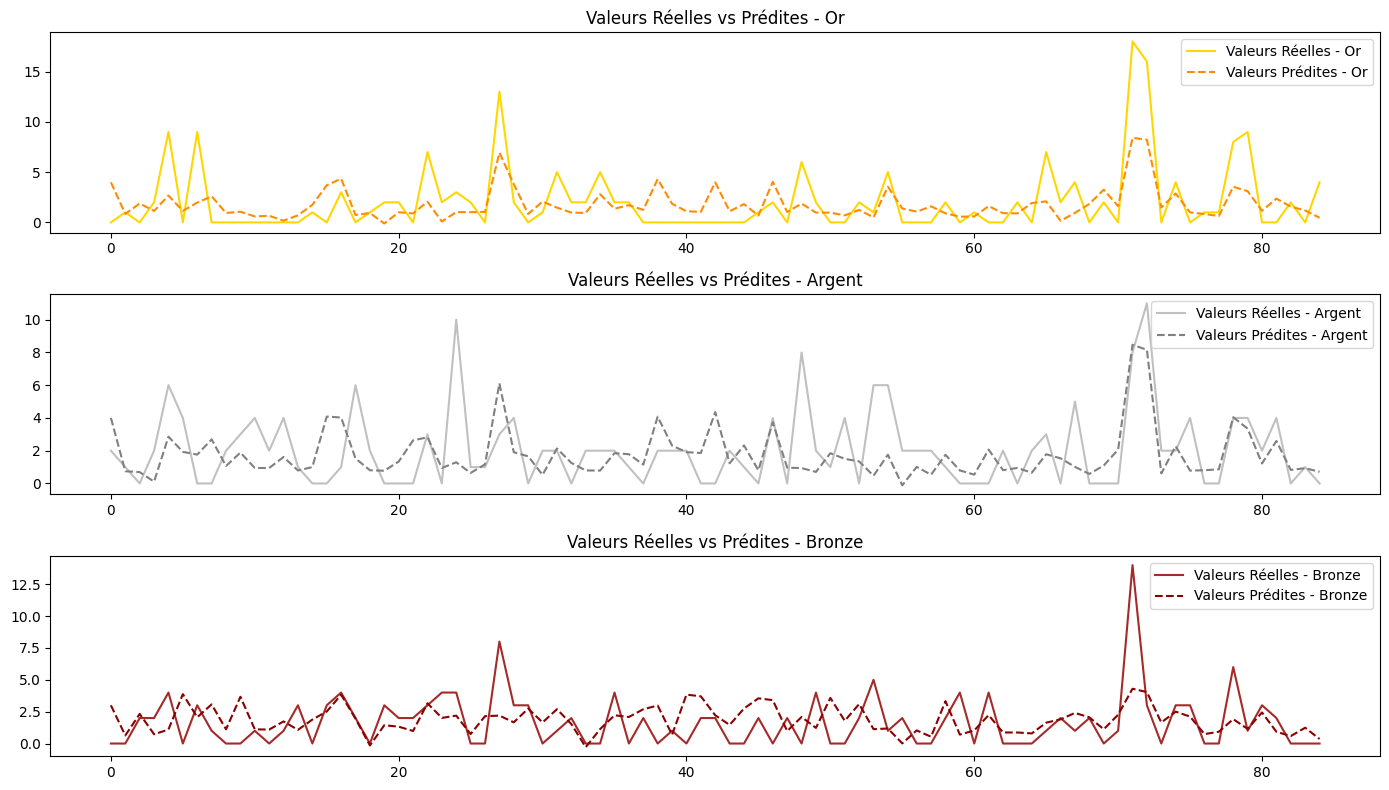

In [9]:
# prédire les valeurs pour le test set
y_pred = model.predict(X_test)

# transformer les valeurs réelles et prédites en 2D
y_test_flat = y_test.reshape(-1, y_test.shape[-1])
y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])

# Tracer les valeurs réelles vs prédites pour chaque type de médaille
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(y_test_flat[:, 0], label='Valeurs Réelles - Or', color='gold')
plt.plot(y_pred_flat[:, 0], label='Valeurs Prédites - Or', color='darkorange', linestyle='--')
plt.legend()
plt.title('Valeurs Réelles vs Prédites - Or')

plt.subplot(3, 1, 2)
plt.plot(y_test_flat[:, 1], label='Valeurs Réelles - Argent', color='silver')
plt.plot(y_pred_flat[:, 1], label='Valeurs Prédites - Argent', color='gray', linestyle='--')
plt.legend()
plt.title('Valeurs Réelles vs Prédites - Argent')

plt.subplot(3, 1, 3)
plt.plot(y_test_flat[:, 2], label='Valeurs Réelles - Bronze', color='brown')
plt.plot(y_pred_flat[:, 2], label='Valeurs Prédites - Bronze', color='darkred', linestyle='--')
plt.legend()
plt.title('Valeurs Réelles vs Prédites - Bronze')

plt.tight_layout()
plt.show()

In [10]:
def predict_medals_next_edition(country, model, scaler, data, encoder, time_steps=3):
    # encodage du pays
    country_encoded = encoder.transform([[country]])
    country_encoded_df = pd.DataFrame(country_encoded, columns=encoder.get_feature_names_out(['country_name']))
    
    # Sélectionner les données du pays
    country_data = data[data['country_name'] == country].sort_values(by='slug_game').iloc[-time_steps:, 2:]
    country_data = pd.concat([country_data.reset_index(drop=True), country_encoded_df], axis=1)
    
    if country_data.shape[0] < time_steps:
        raise ValueError(f"Not enough data for {country} to create a prediction with {time_steps} time steps.")
    
    # Standardiser les données
    expected_features = scaler.n_features_in_
    current_features = country_data.shape[1]
    
    if current_features < expected_features:
        # ajout des 0 si nécessaire
        missing_features = expected_features - current_features
        country_data = np.hstack([country_data.values, np.zeros((country_data.shape[0], missing_features))])
    elif current_features > expected_features:
        # sup des colonnes si nécessaire
        country_data = country_data.iloc[:, :expected_features]

    country_data = scaler.transform(country_data)
    
    # Remodeler les données pour LSTM
    country_data = country_data.reshape(1, time_steps, -1)
    
    predicted_medals = model.predict(country_data)
    return pd.DataFrame(predicted_medals, columns=['GOLD_count', 'SILVER_count', 'BRONZE_count'])

def predict_all_countries_next_edition(model, scaler, data, encoder, time_steps=3):
    unique_countries = data['country_name'].unique()
    predictions = []

    for country in unique_countries:
        try:
            predicted_medals = predict_medals_next_edition(country, model, scaler, data, encoder, time_steps)
            predicted_medals['country_name'] = country
            predictions.append(predicted_medals)
        except ValueError as e:
            print(f"Skipping country {country}: {e}")

    predictions_df = pd.concat(predictions).reset_index(drop=True)
    return predictions_df

predictions_df = predict_all_countries_next_edition(model, scaler, grouped, encoder)

total_predicted_medals = predictions_df[['GOLD_count', 'SILVER_count', 'BRONZE_count']].sum().sum()

# calculer le facteur de normalisation pour ajuster les médailles à la somme cible (987)
medal_target = 987
normalization_factor = medal_target / total_predicted_medals

# appliquer aux prédictions
predictions_df[['GOLD_count', 'SILVER_count', 'BRONZE_count']] *= normalization_factor

# arrondi entier le plus proche
predictions_df[['GOLD_count', 'SILVER_count', 'BRONZE_count']] = predictions_df[['GOLD_count', 'SILVER_count', 'BRONZE_count']].round().astype(int)

predictions_df['total_medals'] = predictions_df[['GOLD_count', 'SILVER_count', 'BRONZE_count']].sum(axis=1)

# sort par nombre total de médailles si égalité prendre or
predictions_df = predictions_df.sort_values(by=['total_medals', 'GOLD_count'], ascending=False)

predictions_df.head(50)

1/1 [==============================] - 0s 12ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Sta

1/1 [==============================] - 0s 30ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Sta

1/1 [==============================] - 0s 17ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 13ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Sta

1/1 [==============================] - 0s 12ms/step
Skipping country Lithuania: Not enough data for Lithuania to create a prediction with 3 time steps.
1/1 [==============================] - 0s 13ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid featur

1/1 [==============================] - 0s 12ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Sta

1/1 [==============================] - 0s 12ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Sta

1/1 [==============================] - 0s 12ms/step


/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/mory/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Sta

,GOLD_count,SILVER_count,BRONZE_count,country_name,total_medals
23,33,32,22,People's Republic of China,87
10,22,22,17,Germany,61
11,21,20,16,Great Britain,57
25,14,20,23,ROC,57
0,10,11,22,Argentina,43
21,21,11,9,New Zealand,41
6,5,10,20,Czech Republic,35
9,9,11,13,France,33
1,14,10,7,Australia,31
20,6,9,16,Netherlands,31


In [11]:
# sauvegarder le modèle
model.save('medal_prediction_model.h5')

/home/mory/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
